In [90]:
import math
import time
import torch
import d2l
from sympy.physics.units import momentum
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from d2l import torch as d2l
import dataset as ppd
from torch.optim import lr_scheduler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

start = time.time()
d2l.use_svg_display()
device = d2l.try_gpu()
train_dataset = ppd.mnist_train
test_dataset = ppd.mnist_test
train_dataloader = ppd.train_dataloader
test_dataloader = ppd.test_dataloader
gradient_values = []
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):

    net.to(device)
    net.train()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):

        metric = d2l.Accumulator(3)  # train_loss,train_acc,num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l = torch.sum(l)
            l.backward()
            trainer.step()

            with torch.no_grad():

                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
        gradients = []
        for param in net[1].parameters():
            gradients.append(param.grad.detach().cpu().numpy())
        gradient_values.append(gradients)
        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # UsingPyTorchIn-Builtscheduler
                scheduler.step()
            else:
                # Usingcustomdefinedscheduler
                for param_group in trainer.param_groups:

                    param_group['lr'] = scheduler(epoch)



    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr


num_inputs = 784
num_outputs = 10
num_hiddens1 = 128
num_hiddens2 = 56
num_hiddens3 = 32

net = nn.Sequential(nn.Flatten(),nn.Linear(num_inputs,num_hiddens1),nn.ReLU(),nn.Dropout(0.0),
                           nn.Linear(num_hiddens1,num_hiddens2),nn.ReLU(),nn.Dropout(0.0),
                           nn.Linear(num_hiddens2,num_hiddens3),nn.ReLU(),
                           nn.Linear(num_hiddens3,num_outputs))
#net.apply(init_normal)
#net.apply(init_xavier)

loss = nn.CrossEntropyLoss()
num_epochs = 30
lr = 0.1
trainer = torch.optim.SGD(net.parameters(), lr=lr,momentum=0.9,weight_decay=5.5e-3,nesterov=False)
#trainer = torch.optim.Adam(params=net.parameters(),lr=lr,amsgrad=True)
#trainer = torch.optim.AdamW(params=net.parameters(),lr=lr,weight_decay=1e-3)
#scheduler = FactorScheduler(factor=0.8, stop_factor_lr=1e-3, base_lr = 0.2)
#scheduler = CosineScheduler(max_update=20, warmup_steps=4,base_lr=0.2, final_lr=1e-2)
#scheduler = CosineScheduler(max_update=20,base_lr=0.2, final_lr=1e-2)
#scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)
#d2l.plot(np.arange(50), [scheduler(t) for t in range(50)])

train(net, train_dataloader, test_dataloader, num_epochs, loss, trainer, device)

end = time.time()
print('用时：',end - start)
d2l.plt.show()




train loss 0.482, train acc 0.830, test acc 0.825
用时： 231.42466139793396


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0652219e-15, -5.915601e-14, -2.8324655e-14, -4.038997e-12, 5.884614e-14, 8.806129e-14, -2.3349566e-15, 8.315631e-14, 1.8670772e-13, -3.8667626e-15, -4.623633e-16, -8.353282e-15, -3.324574e-14, 2.909286e-13, -3.8998075e-16]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0652219e-15, -5.915601e-14, -2.8324655e-14, -4.038997e-12, 5.884614e-14, 8.806129e-14, -2.3349566e-15, 8.315631e-14, 1.8670772e-13, -3.8667626e-15, -4.623633e-16, -8.353282e-15, -3.324574e-14, 2.909286e-13, -3.8998075e-16]


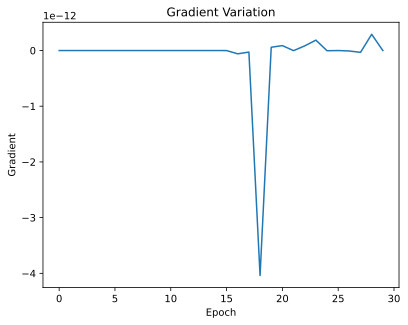

In [111]:
gv = []
for i in range(num_epochs):
    a = gradient_values[i][0][0][150]
    gv.append(a)

print(gv)
print(gv)
    # 绘制梯度随迭代epoch的变化曲线
plt.plot(range(0,num_epochs),gv)
plt.xlabel('Epoch')
plt.ylabel('Gradient')
plt.title('Gradient Variation')
plt.show()

